# Solving classification problems with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

## Libraries installation

In [1]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import catboost
print(catboost.__version__)
!python --version

0.26.1
Python 3.9.12


## Reading the data

In [2]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import datasets

In [3]:
(train_df, test_df) = catboost.datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Preparing your data

Label values extraction

In [4]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)
cat_features = list(range(0, X.shape[1]))

Looking on label balance in dataset

In [5]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

## Select decision boundary

Tutorial on [Youtube](https://youtu.be/xl1fwCza9C8?t=2414)

In [7]:
model = catboost.CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### ROC-AUC

* **True Positive Rate** - fraction of detected positive objectes, want to maximize.
    * Also called recall
    * $$TPR = \frac{TP}{TP + FN}$$



* **False Positive Rate** - fraction of missclassified negative objects, want to minimize.
    * Error on the negative objects.
    * $$FPR = \frac{FP}{FP + TN}$$
    

* **False Negative Rate** - fraction of missclassified positive objects, want to minimize.
    * Error on the positive objects.
    * $$FNR = \frac{FN}{FN + TP}$$

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

![](https://miro.medium.com/max/802/1*Kn0-69rgSKIQzdFN1czpZw.png)

To obtain ROC curve we can use function `get_roc_curve`. It will return 3 lists, FPR, TPR and thresholds.

In [8]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = catboost.Pool(X_validation, y_validation, cat_features=cat_features)

curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

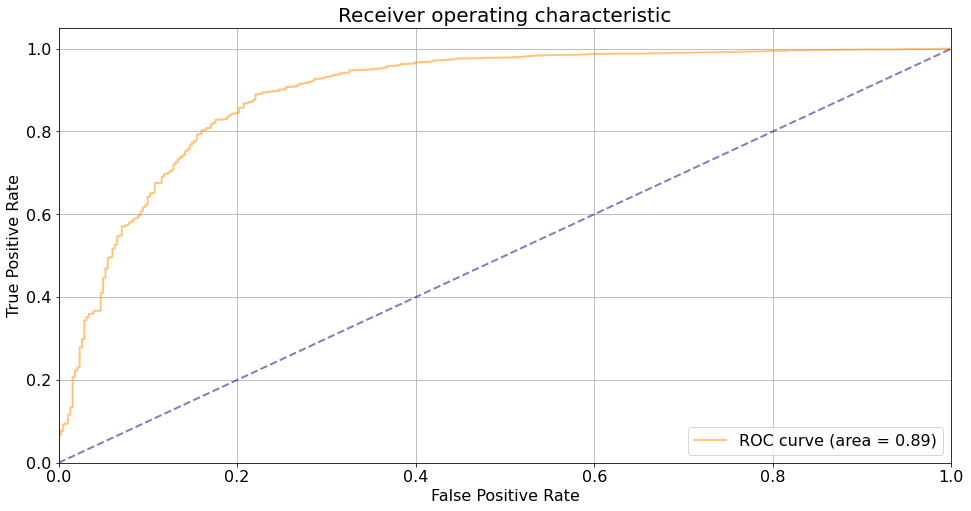

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

## FPR and FNR

We can plot FPR and FNR curves using `get_fpr_curve` and `get_fnr_curve`. Both functions will return two lists, thresholds and metric value.

In [33]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

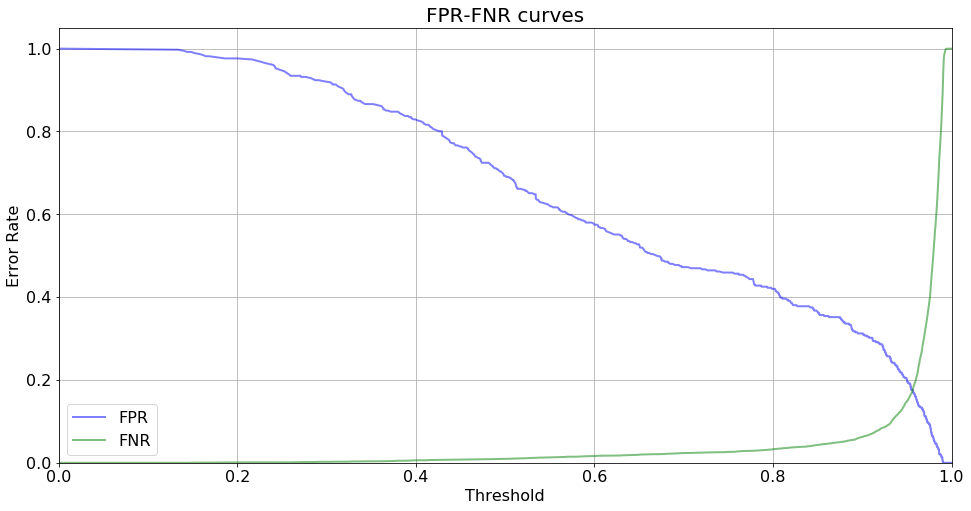

In [34]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

Now we can decide what is more important:
* make an error on positive objects (False Negative Rate)
* make an error on negative objects (False Positive Rate).

Consider an example of detecting an illness. We are creating a model that will say if the person is ill or not based on some screenings.

If the person is ill we do not want to say that he is healthy, but if the person is healthy and we say that he is ill, but is is not that bad since he would do new screenings and find out that he is ok. If we model illness as positive class, we do not want positive predicted as negative, in other words we would keep False Negative Rate (FNR) as small as possible, say 0.01.

To get the decision threshold for FNR (or FPR) we can use `select_threshold` function.

In [35]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.507062966512576
0.9898269287765816
